In [ ]:
!pip install instructor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: jiter
    Found existing installation: jiter 0.7.1
    Uninstalling jiter-0.7.1:
      Successfully uninstalled jiter-0.7.1


# Meta Chain Of Thought (Meta COT)

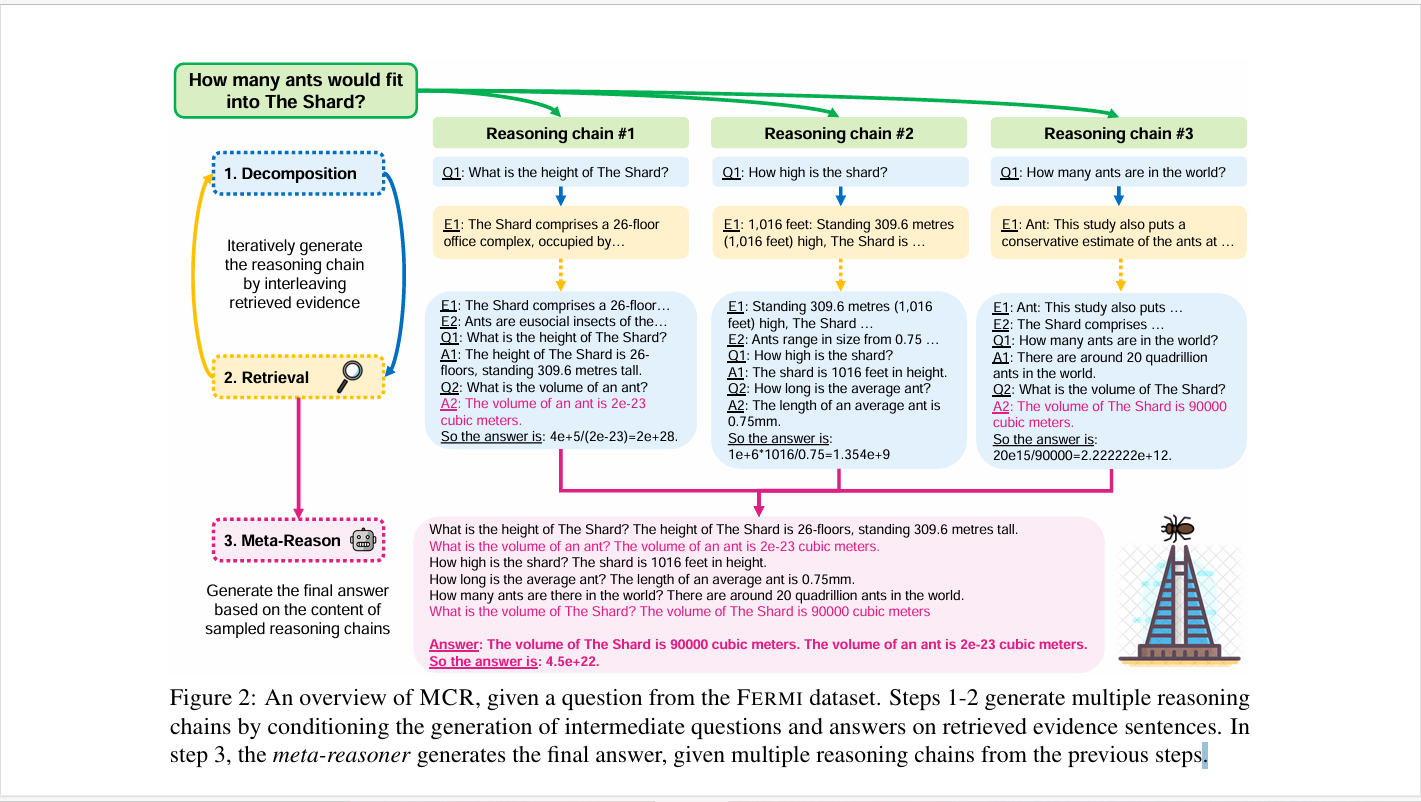

Tổng quan về MCR, đưa ra một câu hỏi từ bộ dữ liệu FERMI. **Bước 1-2 tạo ra nhiều chuỗi lý luận bằng cách tạo điều kiện cho việc tạo ra các câu hỏi và câu trả lời trung gian dựa trên các câu dẫn chứng được thu thập**. Ở bước 3, siêu lý luận tạo ra câu trả lời cuối cùng, **đưa ra nhiều chuỗi lý luận từ các bước trước đó**.


### **Phương pháp:**

Nghiên cứu trình bày một phương pháp trả lời câu hỏi thông qua **siêu suy luận (meta-reasoning)** trên nhiều chuỗi suy luận. Phương pháp tập trung vào tác vụ trả lời câu hỏi trong **miền mở (open-domain QA)**, nơi đầu vào là một câu hỏi $ q $, và các bằng chứng cần thiết để trả lời được lấy từ một hoặc nhiều câu trong tập hợp văn bản $ C $.  

Khi việc trả lời $ q $ yêu cầu nhiều bước suy luận, câu hỏi này có thể được biểu diễn dưới dạng một **chuỗi suy luận** $ r $, được định nghĩa như một danh sách các bộ ba trung gian **(câu hỏi, bằng chứng, câu trả lời)**: $ (q_i, e_i, a_i) $. Trong đó:
- $ e_i \in C $: Một câu có liên quan để trả lời câu hỏi trung gian $ q_i $.

---

### **Mô tả phương pháp:**

#### **Bước 1: Tạo các chuỗi suy luận**
- Với một câu hỏi $ q $, quá trình tạo chuỗi suy luận bao gồm:
  1. **Mô hình phân tách (decomposition model):** Tạo các câu hỏi trung gian $ q_i $, dựa trên câu hỏi gốc $ q $ và các bước suy luận trước đó.
  2. **Thành phần truy xuất (retriever component):** Sử dụng $ q_i $ để truy xuất các bằng chứng liên quan $ e_i $ từ tập hợp văn bản $ C $.

- Quá trình xen kẽ giữa **phân tách và truy xuất**:
  - Dựa trên câu hỏi và bằng chứng thu được, mô hình phân tách tạo ra **câu trả lời trung gian $ a_i $**.
  - Khi tạo chuỗi suy luận, các bằng chứng trung gian được thêm vào đầu chuỗi thay vì xen kẽ với các bước suy luận, nhằm cải thiện độ chính xác.

---

#### **Bước 2: Siêu suy luận trên các chuỗi suy luận**
- **Mô-đun siêu suy luận (meta-reasoner):** Điểm cốt lõi của phương pháp MCR.
  - **Thay vì chỉ lấy câu trả lời từ các chuỗi đã tạo**, mô-đun này sử dụng chúng để **tạo ngữ cảnh đa chuỗi**.
  - **Ngữ cảnh đa chuỗi** gồm tất cả các cặp $ (q_i, a_i) $ từ các chuỗi suy luận mẫu, hoặc cặp $ (q_i, e_i) $ (biến thể được mô tả ở Phụ lục §B.4).

- Ngữ cảnh đa chuỗi và câu hỏi ban đầu được đưa vào mô hình ngôn ngữ lớn (LLM) để trả lời câu hỏi theo từng bước.  
  - Các ví dụ được cung cấp để hướng dẫn mô hình trả lời câu hỏi theo cách chi tiết.  
  - Câu trả lời cuối cùng và chuỗi giải thích được tạo ra bởi mô-đun này.

---

In [ ]:
import instructor
from openai import AsyncOpenAI
from pydantic import BaseModel, Field
import asyncio
from typing import Optional

client = AsyncOpenAI(api_key='sk-RYiDonFCU85Bfr242X2POvCBhlhfHlz8knZQoVjWVJw180s6',
                                              base_url="https://api.chatanywhere.tech/v1")
client = instructor.from_openai(client)


client1 = AsyncOpenAI(api_key='sk-RsaFA9zGH4bOQl8ExoDoVfVTckmdGuOj2mgCGgRl0WfWQU8u',
                                              base_url="https://api.chatanywhere.tech/v1")
client1 = instructor.from_openai(client1)

client2 = AsyncOpenAI(api_key='sk-RsaFA9zGH4bOQl8ExoDoVfVTckmdGuOj2mgCGgRl0WfWQU8u',
                                              base_url="https://api.chatanywhere.tech/v1")
client2 = instructor.from_openai(client2)

class ReasoningAndResponse(BaseModel):
    intermediate_reasoning: str = Field(
        description="""
    Intermediate reasoning steps"""
    )
    correct_answer: str


class MaybeResponse(BaseModel):
    result: Optional[ReasoningAndResponse]
    error: Optional[bool]
    error_message: Optional[str] = Field(
        description="""Informative explanation of why
        the reasoning chain was unable to generate
        a result"""
    )

# Mô hình phân tách (decomposition model)
class QueryDecomposition(BaseModel):
    queries: list[str] = Field(
        description="""A list of queries that need to be
        answered in order to derive the final answer"""
    )


async def generate_queries(query: str):
    return await client1.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": """You are a helpful assistant that
                decomposes a query into multiple sub-queries.""",
            },
            {"role": "user", "content": query},
        ],
        response_model=QueryDecomposition,
    )


async def generate_reasoning_chain(query: str) -> MaybeResponse:
    return await client2.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": """
                Given a question and a context,
                answer the question step-by-step.

                Indicate the intermediate reasoning
                steps.
                """,
            },
            {"role": "user", "content": query},
        ],
        response_model=MaybeResponse,
    )


async def batch_reasoning_chains(
    queries: list[str],
) -> list[MaybeResponse]:
    coros = [generate_reasoning_chain(query) for query in queries]
    results = await asyncio.gather(*coros)
    return results


async def generate_response(query: str, context: list[MaybeResponse]):
    formatted_context = "\n".join(
        [
            f"""
            {item.result.intermediate_reasoning}
            {item.result.correct_answer}
            """
            for item in context
            if not item.error and item.result
        ]
    )

    return await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": """
                Given a question and a context,
                answer the question step-by-step.

                If you are unsure, answer Unknown.
                """,
            },
            {
                "role": "user",
                "content": f"""
                    <question>
                    {query}
                    </question>
                    <context>
                    {formatted_context}
                    </context>
                    """,
            },
        ],
        response_model=ReasoningAndResponse,
    )

import nest_asyncio
if __name__ == "__main__":
    query = """Would Arnold Schwarzenegger have been
    able to deadlift an adult Black rhinoceros at his
    peak strength?"""
    loop = asyncio.get_event_loop()

    # Apply nest_asyncio to the loop
    nest_asyncio.apply(loop)
    decomposed_queries = loop.run_until_complete(generate_queries(query))

    for generated_query in decomposed_queries.queries:
        print(generated_query)
        #> How much weight could Arnold Schwarzenegger
        #> deadlift at his peak strength?
        #> What is the average weight of an adult Black
        #> rhinoceros?

    chains = loop.run_until_complete(batch_reasoning_chains(decomposed_queries.queries))

    for chain in chains:
        print(chain.model_dump_json(indent=2))
        """
        {
          "result": {
            "intermediate_reasoning": "Determining Arnold
            Schwarzenegger's peak deadlift involves
            researching historical records, interviews,
            and Arnold’s competitive powerlifting
            results.",
            "correct_answer": "Arnold Schwarzenegger's
            peak deadlift was reportedly 710 lbs (322
            kg)."
          },
          "error": false,
          "error_message": null
        }
        """
        """
        {
          "result": {
            "intermediate_reasoning": "To determine the
            average weight of an adult Black rhinoceros,
            I need to consult reliable sources such as
            wildlife encyclopedias, zoological databases,
            or scientific articles. Commonly, the average
            weight of adult Black rhinoceros ranges
            between 800 to 1,400 kg.",
            "correct_answer": "The average weight of an
            adult Black rhinoceros ranges between 800 to
            1,400 kg."
          },
          "error": false,
          "error_message": null
        }
        """

    response = asyncio.run(generate_response(query, chains))

    print(response.model_dump_json(indent=2))
    """
    {
      "intermediate_reasoning": "Arnold Schwarzenegger's
      peak deadlift was 710 lbs (322 kg). The average
      weight of an adult Black rhinoceros ranges between
      800 to 1,400 kg (1764 to 3086 lbs). Even at the
      lower end of the rhinoceros weight range (800 kg
      or 1764 lbs), it exceeds Arnold Schwarzenegger's
      peak deadlift capacity of 710 lbs (322 kg).
      Therefore, Arnold Schwarzenegger would not have
      been able to deadlift an adult Black rhinoceros at
      his peak strength.",
      "correct_answer": "No"
    }
    """

ModuleNotFoundError: No module named 'instructor'

In [ ]:
!git clone https://github.com/oriyor/reasoning-on-cots.git

Cloning into 'reasoning-on-cots'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 195 (delta 65), reused 120 (delta 28), pack-reused 0 (from 0)
Receiving objects: 100% (195/195), 2.12 MiB | 25.59 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [ ]:
!pip install -U g4f[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.6/628.6 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.9/52.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7

In [ ]:
# setup
!pip install -q -r /content/reasoning-on-cots/requirements.txt
%cd reasoning-on-cots

Usage: pip3 [options]

ERROR: Invalid requirement: -U g4f[all]
pip3: error: no such option: -U

/content/reasoning-on-cots/reasoning-on-cots


In [ ]:
import os
open_ai_key = "sk-U7ti37t3osaeWme7m88923xFY2UMGVQLkeydTAywi3xI7TOP"#@param {type:"string"}
serp_api_key = "211d1700f6bddb00c4144ed96a8399ac7ee1641852835a52daa8a9bfbbfb241a"#@param {type:"string"}
os.environ["OPENAI_KEY"] = open_ai_key
os.environ["SERP_API_KEY"] = serp_api_key


In [ ]:
import openai
from src.experiments.demo import run_question

dataset = "strategyqa" #@param ["strategyqa", "2wikihop"]
model = "code-davinci-002" #@param ["code-davinci-002", "text-davinci-003", "text-davinci-002"] {allow-input: true}
question_text = "Did Brad Peyton need to know about seismology?" #@param {type:"string"}
answer = "yes" #@param {type:"string"}
num_decompositions = 3 #@param {type:"slider", min:1, max:5, step:1}

run_question(question_text=question_text, dataset=dataset, answer=answer, model=model, num_decomps=num_decompositions)


Running decomposition + retrieval models

====================== Decomposition 0 ======================
Read from cache for query: Did Brad Peyton need to know about seismology?, cached snippet: Answering Questions by Meta-Reasoning over Multiple ...: Answer: Brad Peyton is a film director, writer, and producer. Seismology is the study of earthquakes. San Andreas is a film directed by Brad Peyton, about a massive earthquake caused by the San Andreas Fault. So the final answer is: Yes.
exception thrown, sleeping...
免费API限制使用gpt-3.5-turbo，gpt-4 和 embeddings模型，如有更多需求，请访问 https://buyca.tech 购买付费API。The free account is limited to use gpt-3.5-turbo, gpt-4 and embeddings. If you have additional requirements, please visit https://buyca.tech to purchase a premium key.
sleeping for 30 seconds
{'sk-RYiDonFCU85Bfr242X2POvCBhlhfHlz8knZQoVjWVJw180s6': datetime.datetime(2024, 12, 1, 16, 56, 37, 486625)}
finished sleeping
exception thrown, sleeping...
免费API限制使用gpt-3.5-turbo，gpt-4 和 embeddings模型，如有更多需

KeyboardInterrupt: 

In [ ]:
import dataclasses
from typing import Dict

from src.common.config import Config
from src.dataclasses import QuestionV1
from src.experiments.e2e.run import (
    _set_entailment_input,
    _call_gpt_for_entailment_with_batching,
)
from src.gpt3_accessors.gpt_accessor_factory import GptAccessorFactory
from src.pred_evaluators.evaluators_factory import EvaluatorsFactory
from src.prompting.prompt_factory import PromptFactoryDict


def run_question(
    question_text: str,
    dataset: str,
    answer: str,
    model: str = "code-davinci-002",
    num_decomps: int = 3,
) -> Dict:
    """
    runs the question, first by populating decomps and then by running mcr
    """

    # load config
    Config().load(f"src/config/{dataset}/config_with_retrieval_contexts_first.json")

    # set up object
    question = QuestionV1(
        question=question_text,
        prompt=PromptFactoryDict[f"{dataset}_decomposition"],
        gpt3_accessor=GptAccessorFactory().get_instance(
            "gpt_accessor_with_retrieval_context_first"
        ),
        model=model,
        num_decompositions=num_decomps,
    )
    question.populate()

    # set mcr input
    question_with_mcr = _set_entailment_input(
        {"question": dataclasses.asdict(question), "metadata_gold_answer": answer},
        PromptFactoryDict[f"{dataset}_mcr"],
        entailment_values={
            "shuffle_context": False,
            "use_ir_contexts": False,
            "use_qa_pairs": True,
            "question_prompt_prefix": "",
            "stop_condition": "#",
            "model": model,
        },
        sa_contexts_first=True,
        prefix=f"mcr",
    )

    print("\n====================== Running meta-reasoner ======================")
    res = _call_gpt_for_entailment_with_batching(
        [question_with_mcr],
        EvaluatorsFactory().get_instance("bamboogle"),
        entailment_values={
            "shuffle_context": False,
            "use_ir_contexts": False,
            "use_qa_pairs": True,
            "question_prompt_prefix": "",
            "stop_condition": "#",
            "model": model,
        },
        prefix=f"mcr",
    )[0]
    print(f"F1: {res['mcr_acc@mte']}")



dataset = "strategyqa"  # 2wikihop/strategyqa
question_text = "Did Brad Peyton need to know about seismology?"
answer = "yes"  # gold answer

run_question(
    question_text=question_text,
    dataset=dataset,
    answer=answer,
    model="code-davinci-002",
)


Running decomposition + retrieval models

====================== Decomposition 0 ======================
Read from cache for query: Did Brad Peyton need to know about seismology?, cached snippet: Answering Questions by Meta-Reasoning over Multiple ...: Answer: Brad Peyton is a film director, writer, and producer. Seismology is the study of earthquakes. San Andreas is a film directed by Brad Peyton, about a massive earthquake caused by the San Andreas Fault. So the final answer is: Yes.
exception thrown, sleeping...
免费API限制使用gpt-3.5-turbo，gpt-4 和 embeddings模型，如有更多需求，请访问 https://buyca.tech 购买付费API。The free account is limited to use gpt-3.5-turbo, gpt-4 and embeddings. If you have additional requirements, please visit https://buyca.tech to purchase a premium key.
sleeping for 30 seconds
{'sk-RYiDonFCU85Bfr242X2POvCBhlhfHlz8knZQoVjWVJw180s6': datetime.datetime(2024, 12, 1, 16, 58, 57, 479218)}


KeyboardInterrupt: 

In [ ]:
import time

import openai
import os
import datetime
from dotenv import load_dotenv

from openai.error import RateLimitError, InvalidRequestError
import json

from src.common.logger import get_logger
from src.serpapi.serpapi import google, get_question_wiki_snippet
from g4f.client import Client

client = Client()
logger = get_logger()

# load openai keys from env, and set a random key at random
load_dotenv()
openai.api_key = os.getenv("OPENAI_KEY")
openai.api_base = "https://api.chatanywhere.tech/v1"
open_ai_keys = [openai.api_key]
last_time_out_for_keys = {k: datetime.datetime.min for k in open_ai_keys}
sleep_time_per_key = 30
print()


def call_gpt(cur_prompt, stop="\n"):
    """
    call the gpt-3 api
    """
    print("calling gpt")
    ans = client.chat.Completions.create(
        model="code-davinci-002",
        max_tokens=1,
        stop=stop,
        prompt=cur_prompt,
        temperature=0,
        logprobs=5,
    )
    returned = ans["choices"][0]["text"]

    return ans


def greenify(input):
    return "\x1b[102m" + input + "\x1b[0m"


def yellowfy(input):
    return "\x1b[106m" + input + "\x1b[0m"


#
# def format_question(question: str, show_question=True) -> str:
#     """
#     format a question that wil be presented to gpt-3 validator
#     """
#     # init
#     res = "Provide a yes or no answer to the question given the following facts.\n"
#     intermediate_res = []
#
#     # get a list of facts and intermediate answers
#     question_liines = question.split("\n")
#     facts, intermediate_answers = [], []
#     for line in question_liines:
#         if line.startswith(QUESTION_PREFIX):
#             question = line.split(QUESTION_PREFIX)[1]
#             res += f"{question}\n"
#         if line.startswith(FOLLOW_UP_PREFIX):
#             facts.append(line.split(FOLLOW_UP_PREFIX)[1])
#         if line.startswith(INTERMEDIATE_ANS_PREFIX):
#             intermediate_answers.append(line.split(INTERMEDIATE_ANS_PREFIX)[1])
#
#     for i, (fact, ans) in enumerate(zip(facts, intermediate_answers)):
#         if show_question:
#             res += f"{i + 1}. {fact} {ans}\n"
#             intermediate_res.append(f"{res}Answer:\n")
#         else:
#             res += f"{i + 1}. {ans}\n"
#             intermediate_res.append(f"{res}Answer:\n")
#
#     res += "Answer:\n"
#
#     return intermediate_res
#
#
# def call_gpt3_for_question(curr_question: Question) -> Question:
#     """
#     calls gpt-3 an populates
#     """
#     # create the set of questions
#     intermediate_questions = []
#     for decmop in curr_question.decompositions:
#         question_with_decomp = f"{QUESTION_PREFIX}{curr_question.question}\n{decmop}"
#         intermediate_questions += format_question(question_with_decomp)
#     qusetion_intermediate_questions = set(intermediate_questions)
#     qusetion_intermediate_questions_with_answers = []
#
#     # print
#     for intermediate_question in qusetion_intermediate_questions:
#         gpt_res = call_gpt(intermediate_question[:-1], "\n")
#         gpt3_probs = {
#             k: math.exp(v)
#             for k, v in gpt_res["choices"][0]["logprobs"]["top_logprobs"][0]
#             .to_dict()
#             .items()
#         }
#         yes_probs = sum([v for k, v in gpt3_probs.items() if "yes" in k.lower()])
#         no_probs = sum([v for k, v in gpt3_probs.items() if "no" in k.lower()])
#         probs = {"yes": yes_probs, "no": no_probs, "other": 1 - yes_probs - no_probs}
#         probs = {
#             **probs,
#             **{
#                 "yes_normalized": probs["yes"] / (probs["yes"] + probs["no"]),
#                 "no_normalized": probs["no"] / (probs["yes"] + probs["no"]),
#             },
#         }
#         probs
#         print(probs)
#         qusetion_intermediate_questions_with_answers.append(
#             IntermediateQuestionWithAnswer(
#                 intermediate_question=intermediate_question, answer=probs
#             )
#         )
#
#     # set var
#     curr_question.intermediate_questions_with_answers = (
#         qusetion_intermediate_questions_with_answers
#     )
#     return curr_question


def change_openaikey_and_sleep():
    """
    if we encountered a time-out, change the key and sleep if necessary
    """
    # set the date for current time out
    last_time_out_for_keys[openai.api_key] = datetime.datetime.now()

    # get first time out and calc the time that passed
    first_timed_out_key = min(last_time_out_for_keys, key=last_time_out_for_keys.get)
    time_since_first_time_out = (
        datetime.datetime.now() - last_time_out_for_keys[first_timed_out_key]
    )

    # change the key to be the one that was last timed out
    openai.api_key = first_timed_out_key
    logger.info(f"switched to openaikey: {openai.api_key}")

    # sleep if the time that passed between now and when we last used the key is smaller than a threshold, sleep
    if time_since_first_time_out.seconds < sleep_time_per_key:
        sleeping_time = sleep_time_per_key - time_since_first_time_out.seconds
        print(f"sleeping for {sleeping_time} seconds")
        print(last_time_out_for_keys)
        time.sleep(sleep_time_per_key - time_since_first_time_out.seconds)
        print("finished sleeping")


def gpt_simple_generator(
    prompt, model="code-davinci-002", stop_condition="\n", temperature=0, max_tokens=256
):
    retries = 6
    for i in range(retries):
        try:
            print(f"Using: {openai.api_key}")
            ans = client.chat.Completions.create(
                model=model,
                max_tokens=max_tokens,
                stop=stop_condition,
                prompt=prompt,
                temperature=temperature,
                # logprobs=5,
            )
            returned = [res["text"] for res in ans["choices"]]

            # if the answer is of size 1, we were prompted with 1 prompt so print it and return
            if len(returned) == 1:
                print(greenify(returned[0]), end="")
                return returned[0], {}

            # else iterate all results and return a list
            else:
                for res in returned:
                    print(greenify(res), end="")
                return returned, {}

        except RateLimitError as e:
            print(f"exception thrown, sleeping...")
            print(e)
            change_openaikey_and_sleep()

        except InvalidRequestError as e:
            print(
                "Invalid request caught, maybe the prompt is too long? Sleeping, plz take a look!"
            )
            time.sleep(30)
            # return "" if type(prompt) == str else ["" for _ in range(len(prompt))], {}

        except Exception as e:
            print(e)
            time.sleep(90)


def call_gpt_self_ask(cur_prompt, stop):
    res = ""
    retries = 3
    # iterate decomposition for 5 steps
    for i in range(5):
        # get gpt ans with retries
        for i in range(retries):
            try:
                ans = client.chat.Completions.create(
                    model="code-davinci-002",
                    max_tokens=512,
                    stop=["Context:", "#"],
                    prompt=cur_prompt,
                    temperature=0.7,
                )
                break
            except Exception as e:
                print("exception thrown, sleeping...", e)
                time.sleep(60)
                print("finished sleeping")

        # add context
        returned = ans["choices"][0]["text"]
        res += returned
        cur_prompt += returned
        if "Follow up: " in returned:
            question = returned.split("Follow up: ")[-1].replace("\n", "")
            retrieval = get_question_wiki_snippet(question, cache=True)
            cur_prompt += f"Context: {retrieval}\n"
            res += f"Context: {retrieval}\n"
        if "So the final answer is: " in returned:
            print(greenify(res), end="")
            return res
        print(greenify(res), end="")

    return res
